In [1]:
import tarfile
import os
import glob
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, roc_auc_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import GridSearchCV


# 1. Estrazione del dataset
tar_path = '/Users/albertozanelli/Desktop/astrostatistics_bicocca_2025/solutions/higgs.tar.gz'    # Assicurati che il percorso sia corretto
extract_path = 'higgs_data'

if not os.path.exists(extract_path):
    os.makedirs(extract_path)

with tarfile.open(tar_path, 'r:gz') as tar:
    tar.extractall(path=extract_path, filter="data")
    print(f"Archivio estratto in: {extract_path}")

# 2. Caricamento del CSV
csv_files = glob.glob(os.path.join(extract_path, '*.csv'))
if not csv_files:
    raise FileNotFoundError("Nessun file CSV trovato nella cartella estratta.")
csv_path = csv_files[0]
print(f"Carico i dati da: {csv_path}")

df = pd.read_csv(csv_path)
print("Dimensioni del dataset:", df.shape)
print("Prime colonne:", df.columns.tolist())
#print(df.head())

# Qui assumiamo che:
# - la colonna 'Label' contenga 's' (signal) o 'b' (background)
# - eventualmente ci sia una colonna 'EventId' da rimuovere

if df['Label'].dtype == object:
    df['Label'] = df['Label'].map({'s': 1, 'b': 0})

# Rimuovo 'EventId' se esiste, e separo X / y
drop_cols = ['EventId'] if 'EventId' in df.columns else []
X = df.drop(columns=drop_cols + ['Label']+ ['Weight'])
y = df['Label']

# 3. Imputazione dei missing values (-999 -> NaN -> mediana)
X.replace(-999, np.nan, inplace=True)
#imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(X, columns=X.columns)

print(X.head())



Archivio estratto in: higgs_data
Carico i dati da: higgs_data/higgs.csv
Dimensioni del dataset: (250000, 33)
Prime colonne: ['EventId', 'DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_tau_pt', 'PRI_tau_eta', 'PRI_tau_phi', 'PRI_lep_pt', 'PRI_lep_eta', 'PRI_lep_phi', 'PRI_met', 'PRI_met_phi', 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_leading_pt', 'PRI_jet_leading_eta', 'PRI_jet_leading_phi', 'PRI_jet_subleading_pt', 'PRI_jet_subleading_eta', 'PRI_jet_subleading_phi', 'PRI_jet_all_pt', 'Weight', 'Label']
   DER_mass_MMC  DER_mass_transverse_met_lep  DER_mass_vis  DER_pt_h  \
0       138.470                       51.655        97.827    27.980   
1       160.937                       68.768       103.235    48.146   
2           NaN                      162.172       1

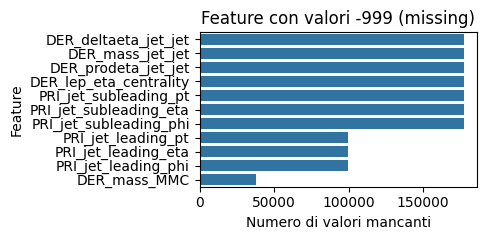

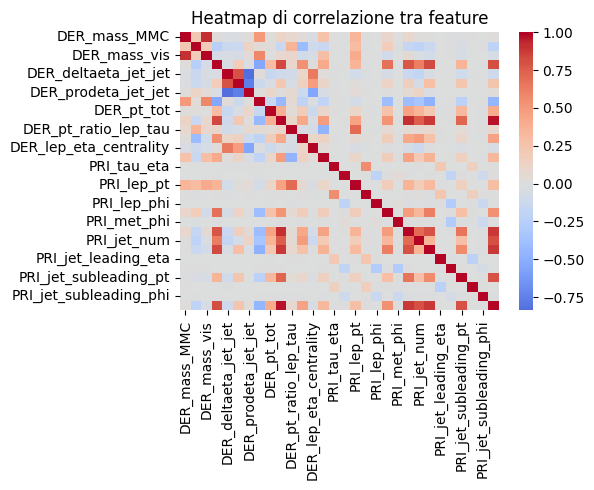

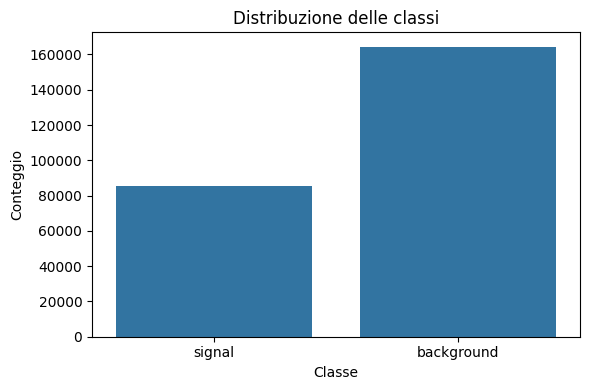

<Figure size 1200x1000 with 0 Axes>

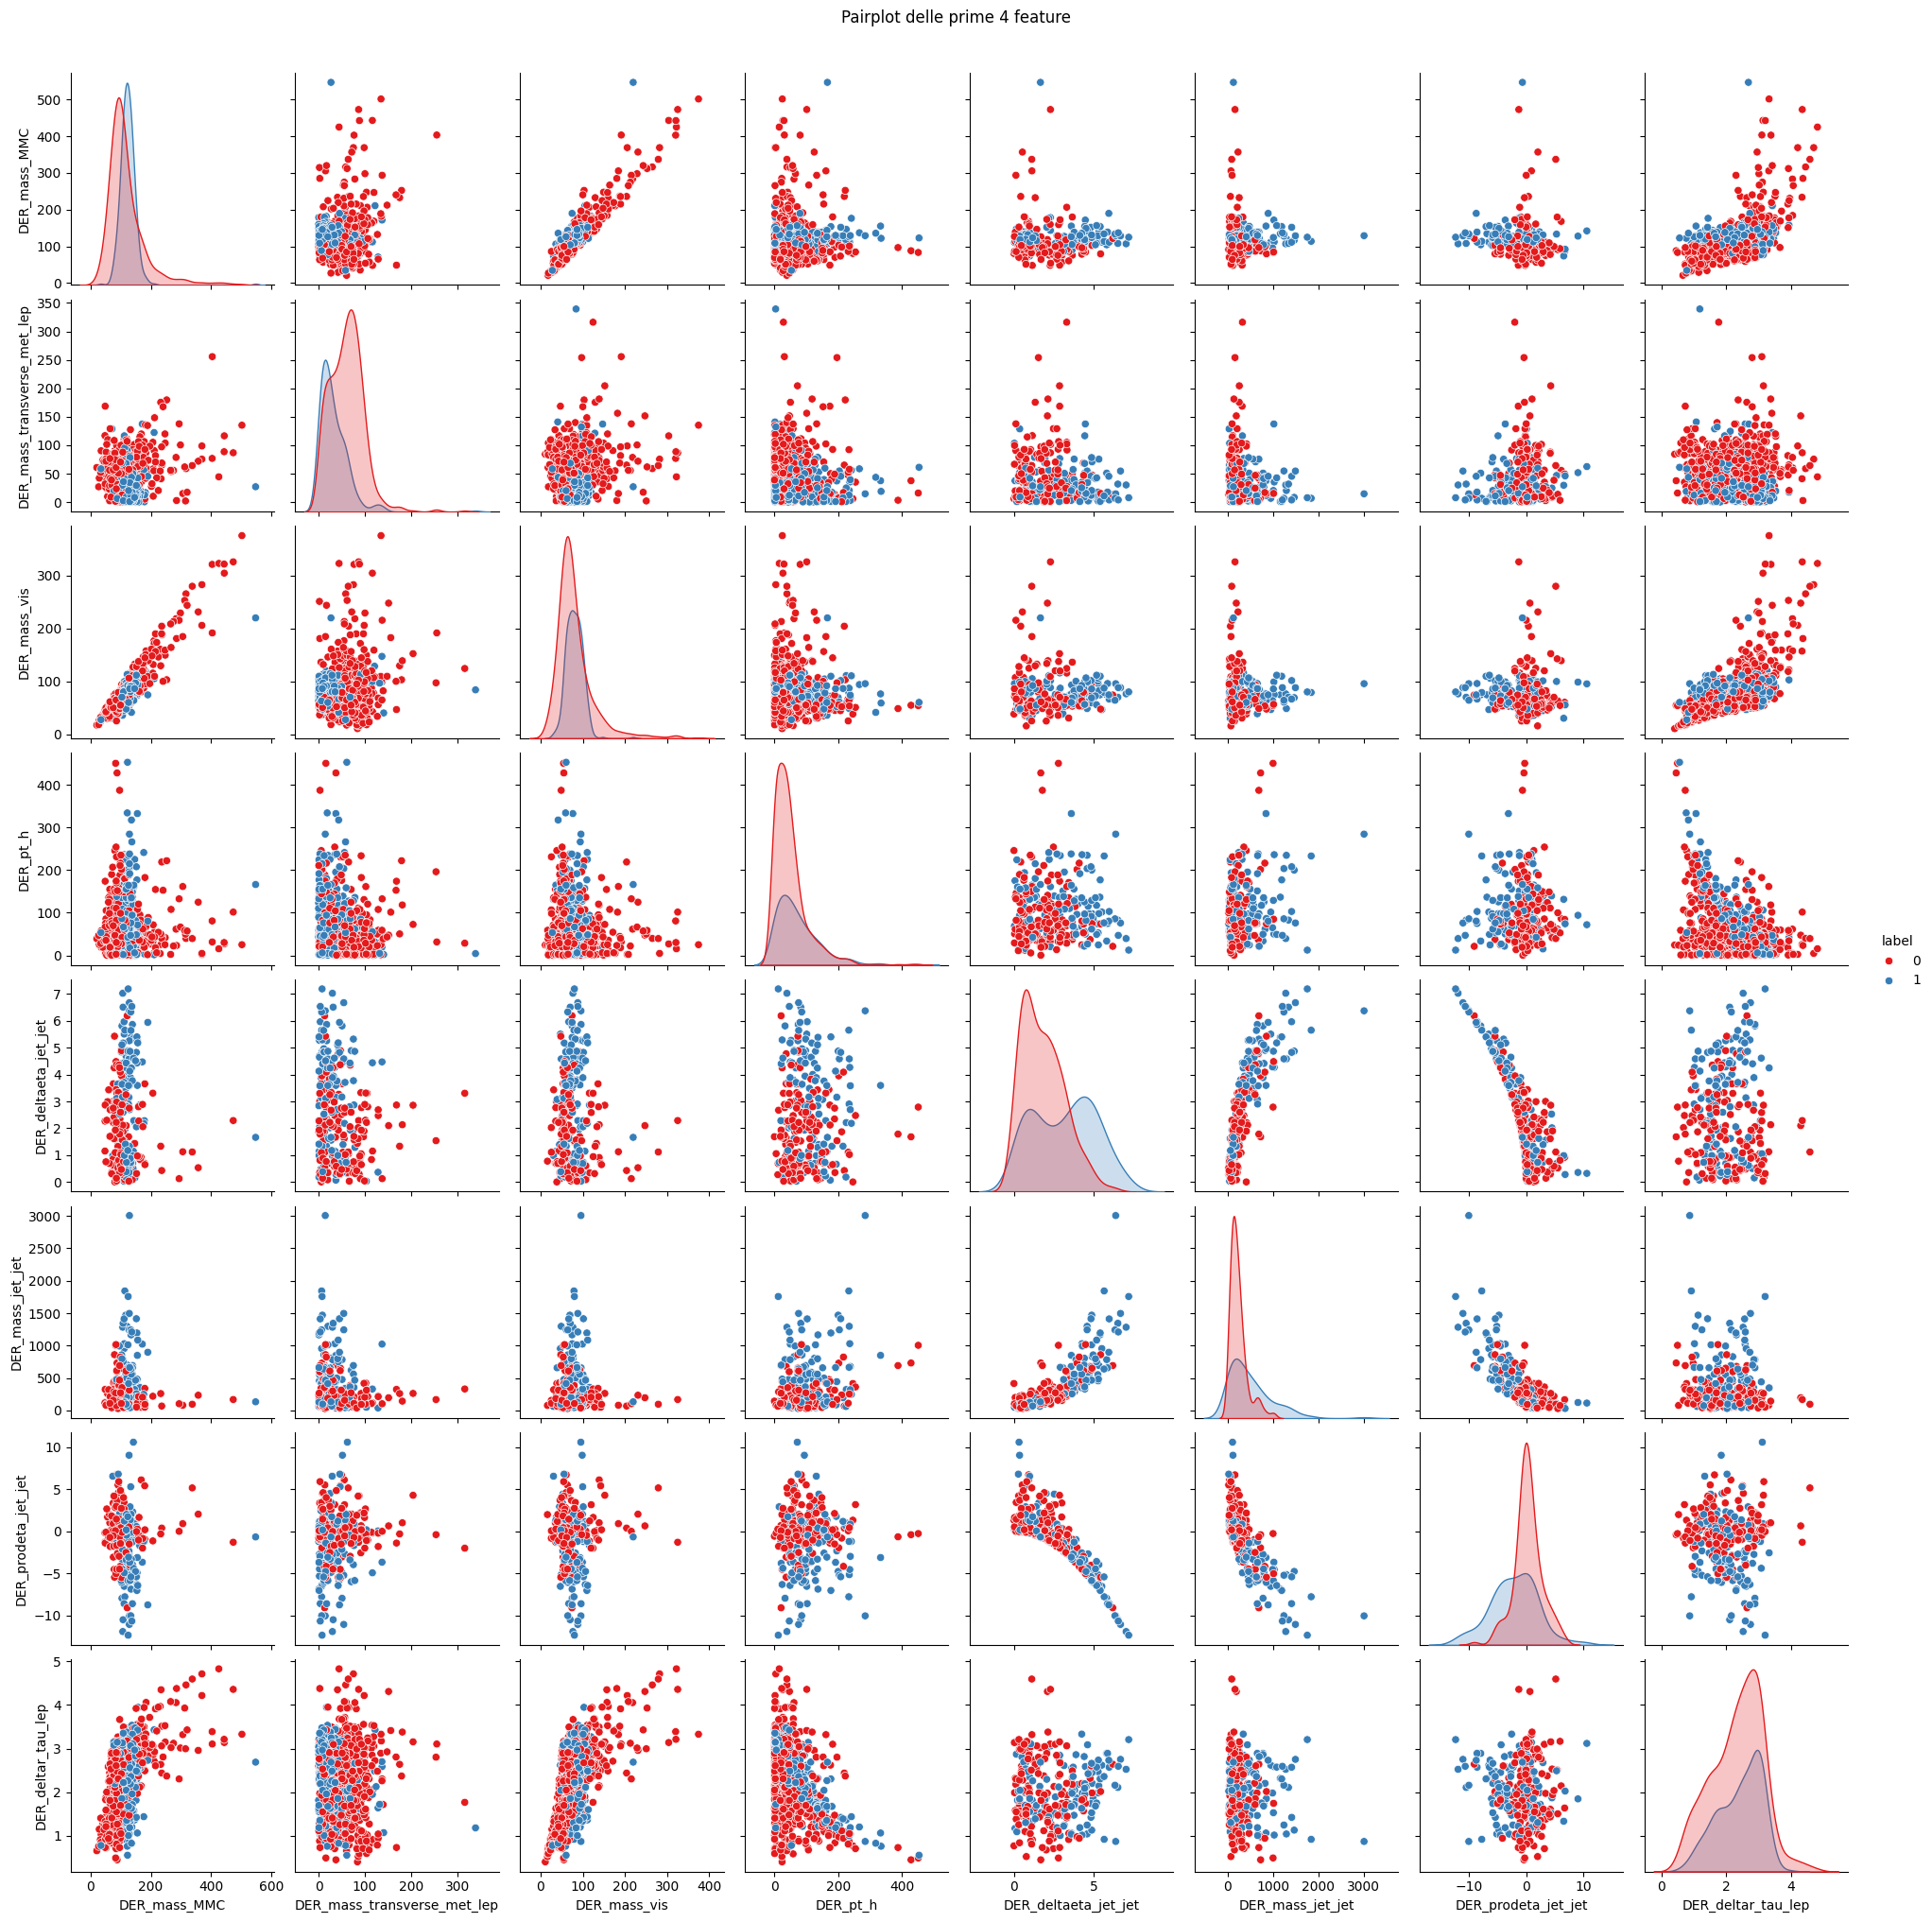

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def esplora_dataset(X, y):

    # Controllo valori mancanti (-999)
    missing_counts = X.isna().sum()
    missing_counts = missing_counts[missing_counts > 0].sort_values(ascending=False)
    
    if not missing_counts.empty:
        plt.figure(figsize=(5, 2.5))
        sns.barplot(x=missing_counts.values, y=missing_counts.index)
        plt.title("Feature con valori -999 (missing)")
        plt.xlabel("Numero di valori mancanti")
        plt.ylabel("Feature")
        plt.tight_layout()
        plt.show()
    else:
        print("Nessun valore -999 trovato nel dataset.")
    
    # Heatmap correlazioni
    plt.figure(figsize=(6, 5))
    corr = X.corr()
    sns.heatmap(corr, cmap='coolwarm', center=0, annot=False)
    plt.title("Heatmap di correlazione tra feature")
    plt.tight_layout()
    plt.show()
    
    # Distribuzione classi
    plt.figure(figsize=(6,4))
    sns.countplot(x=y.map({0: "background", 1: "signal"}))
    plt.title("Distribuzione delle classi")
    plt.xlabel("Classe")
    plt.ylabel("Conteggio")
    plt.tight_layout()
    plt.show()
    
    # Pairplot sulle prime 4 feature (sample 1000 righe)
    sample = X.copy()
    sample['label'] = y
    plt.figure(figsize=(12, 10))
    sns.pairplot(sample.sample(min(1000,len(sample))), vars=sample.columns[:8], hue='label', palette='Set1')
    plt.suptitle("Pairplot delle prime 4 feature", y=1.02)
    plt.show()

esplora_dataset(X_imputed, y)


In [3]:
# 4. Imputation of missing values
imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(imputer.fit_transform(X_imputed), columns=X.columns)

# 5. Scaling (StandardScaler)
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_imputed), columns=X.columns)

# 5. Split train/val/test
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_scaled, y, test_size=0.20, random_state=42, stratify=y)

# Suddivido l'80% (train_val) in train e validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.20, random_state=42, stratify=y_train_val)

print("Shape train:", X_train.shape)
print("Shape validation:", X_val.shape)
print("Shape test:", X_test.shape)

# 6. Campiono un sottoinsieme per GridSearch (per velocizzare)
sample_frac = 0.20
X_train_sample, _, y_train_sample, _ = train_test_split(
    X_train, y_train,
    train_size=sample_frac,
    random_state=42,
    stratify=y_train
)
print("Shape campione per iper-parametri:", X_train_sample.shape)

# 7. Definisco la funzione che crea il modello Keras
def create_model(hidden_units=64, dropout_rate=0.3, learning_rate=1e-3):
    model = keras.Sequential([
        layers.Input(shape=(X_train.shape[1],)),
        layers.Dense(hidden_units, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['AUC']
    )
    return model

# 8. Wrapping con KerasClassifier
keras_clf = KerasClassifier(
    model=create_model,
    verbose=0,
    )

# 9. Griglia di iperparametri
vparam_grid = {
    'model__hidden_units': [64, 128],
    'model__dropout_rate': [0.2, 0.4],
    'model__learning_rate': [1e-3, 1e-4],
    'batch_size': [256, 512],
    'epochs': [10, 20]
}


grid_search = GridSearchCV(
    estimator=keras_clf,
    param_grid=vparam_grid,
    scoring='roc_auc',
    cv=3,
    verbose=1,
    n_jobs=-1
)

print("Avvio GridSearchCV...")
grid_search.fit(X_train_sample, y_train_sample)

print("Migliori parametri trovati:", grid_search.best_params_)
print("Miglior AUC in CV:", grid_search.best_score_)

# 11. Alleno il modello definitivo su train+val con i parametri ottimali
best_params = grid_search.best_params_
model_full = create_model(
    hidden_units=best_params['model__hidden_units'],
    dropout_rate=best_params['model__dropout_rate'],
    learning_rate=best_params['model__learning_rate']
)

history = model_full.fit(
    X_train_val, y_train_val,
    validation_data=(X_val, y_val),
    batch_size=best_params['batch_size'],
    epochs=best_params['epochs'],
    verbose=1
)

# 12. Valutazione sul test set
y_pred_prob = model_full.predict(X_test).ravel()
y_pred = (y_pred_prob > 0.5).astype(int)

auc_test = roc_auc_score(y_test, y_pred_prob)
report = classification_report(y_test, y_pred, target_names=['Background', 'Signal'])

print("\n--- Risultati sul Test Set Finale ---")
print("Test ROC AUC:", auc_test)
print("\nClassification Report:\n", report)

Shape train: (160000, 30)
Shape validation: (40000, 30)
Shape test: (50000, 30)
Shape campione per iper-parametri: (32000, 30)
Avvio GridSearchCV...
Fitting 3 folds for each of 32 candidates, totalling 96 fits
Migliori parametri trovati: {'batch_size': 256, 'epochs': 20, 'model__dropout_rate': 0.2, 'model__hidden_units': 128, 'model__learning_rate': 0.001}
Miglior AUC in CV: 0.894332836611731
Epoch 1/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - AUC: 0.8259 - loss: 0.4761 - val_AUC: 0.8948 - val_loss: 0.3886
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 767us/step - AUC: 0.8884 - loss: 0.3995 - val_AUC: 0.8981 - val_loss: 0.3822
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 775us/step - AUC: 0.8922 - loss: 0.3914 - val_AUC: 0.9008 - val_loss: 0.3776
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 763us/step - AUC: 0.8945 - loss: 0.3875 - val_AUC: 0.9020 - val_loss: 0.3742
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 711us/step - AUC: 0.8986 - loss: 0.3809 - val_AUC: 0.9037 - val_loss: 0.3723
Epoch 

/var/folders/57/gp84p4410yx1sr6bqvtc5qs00000gn/T/ipykernel_27533/2383754133.py:76: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


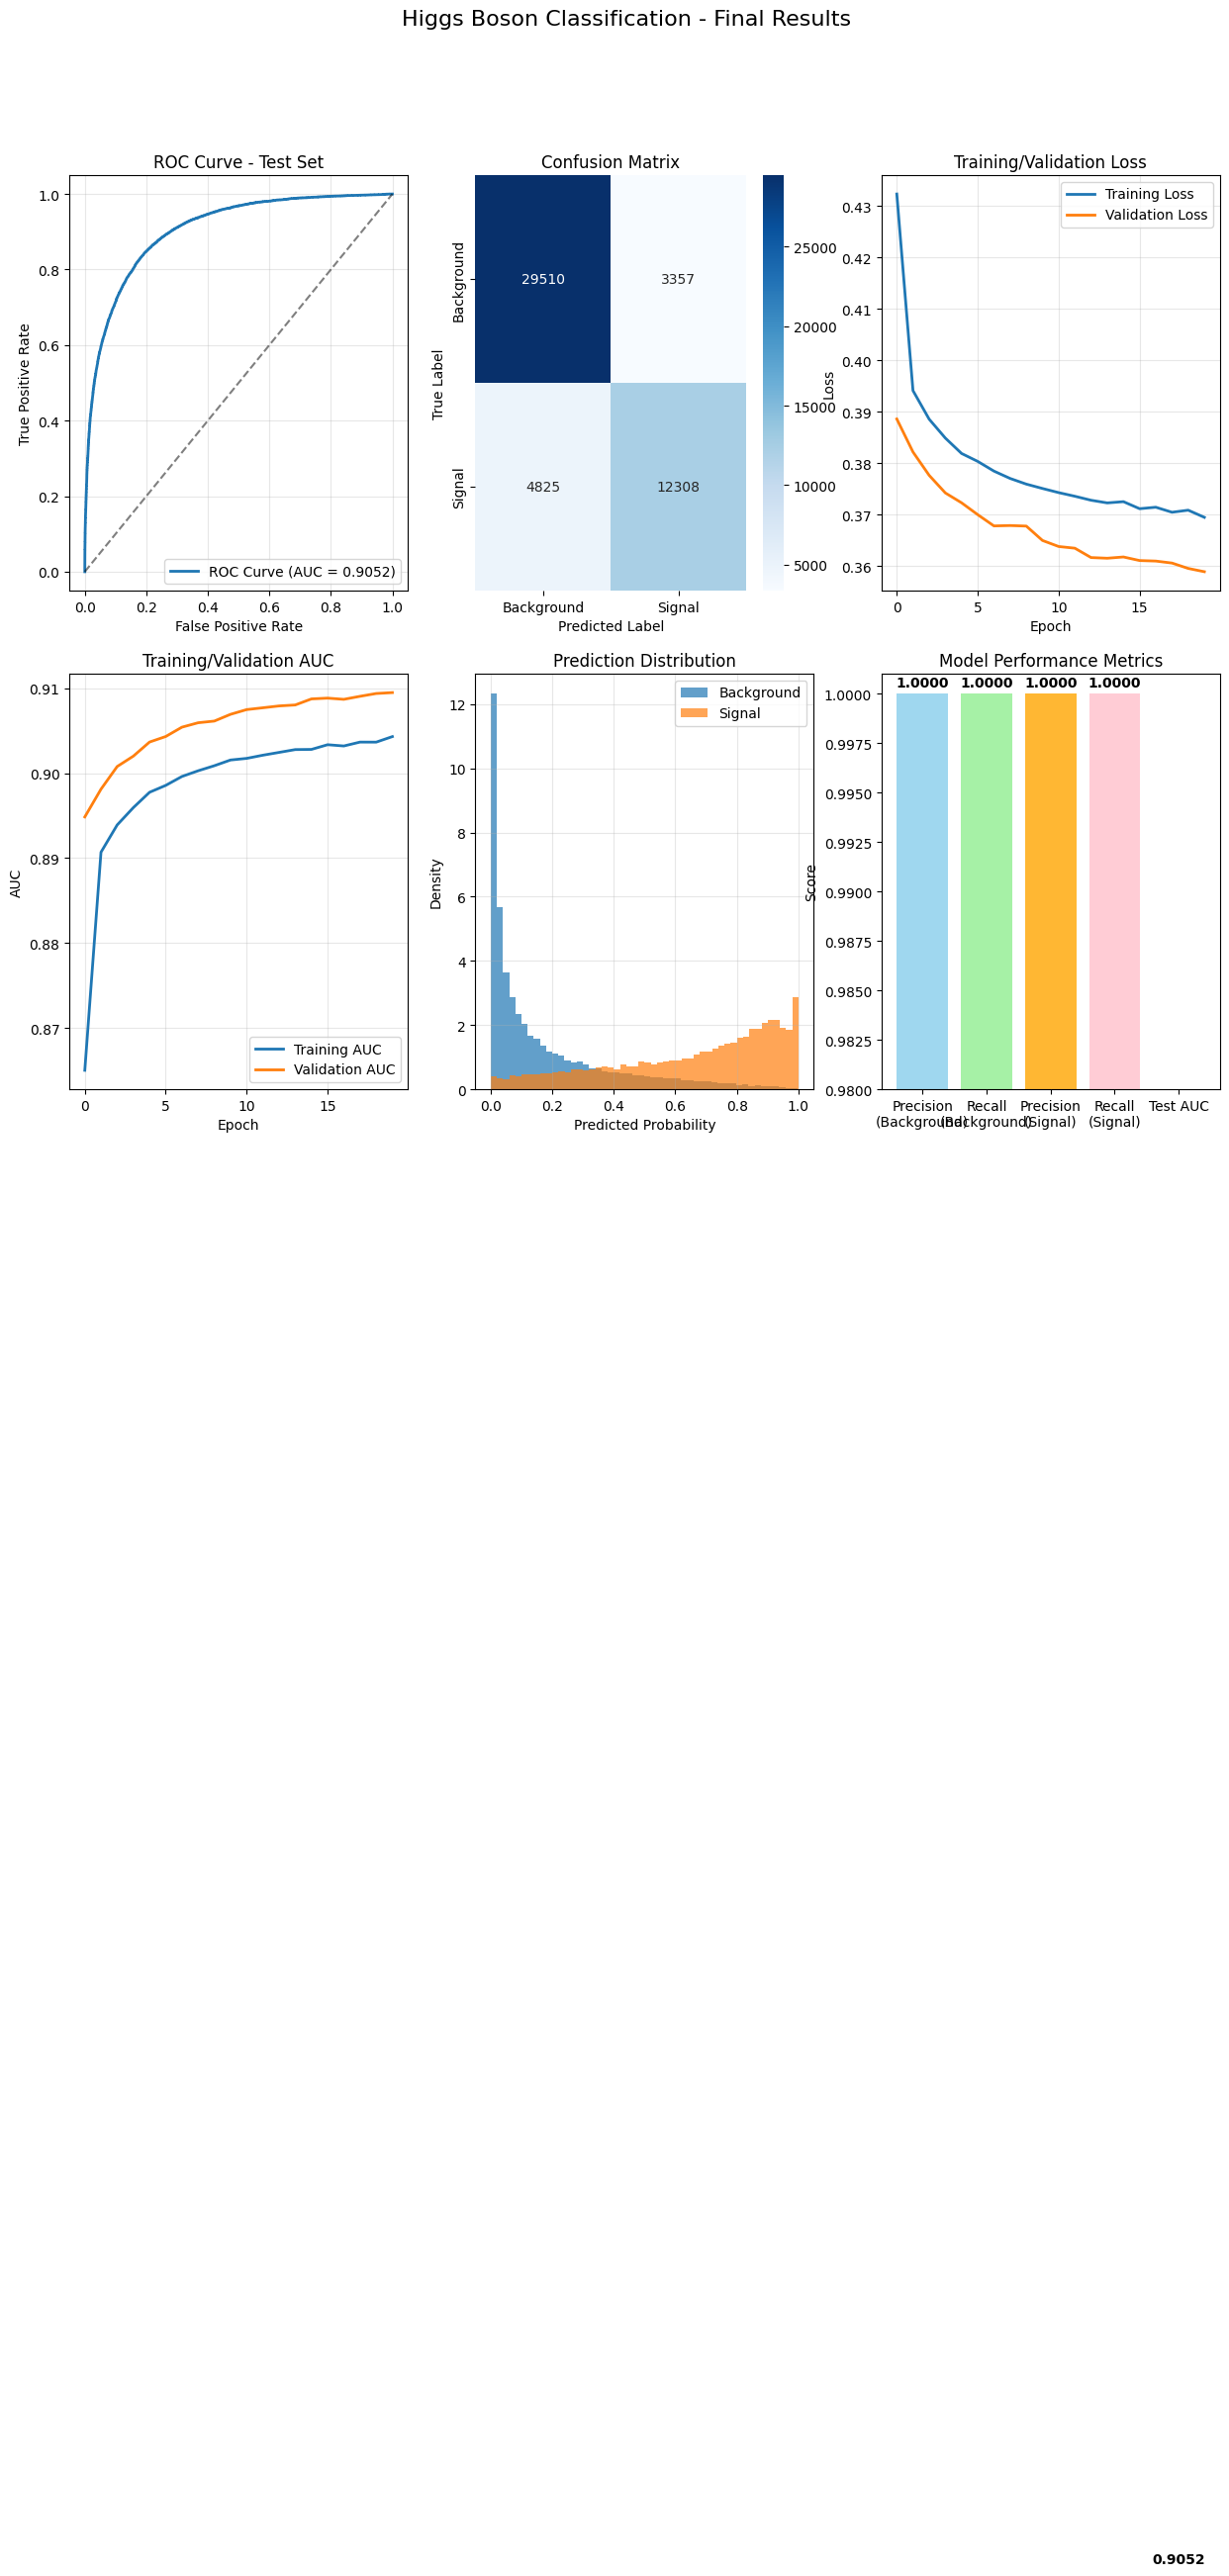

=== RIEPILOGO RISULTATI FINALI ===
Best Parameters: {'batch_size': 256, 'epochs': 20, 'model__dropout_rate': 0.2, 'model__hidden_units': 128, 'model__learning_rate': 0.001}
Test ROC AUC: 0.905151
Test Accuracy: 0.836360
Signal Detection Rate: 0.718380
Background Rejection Rate: 0.897861


In [4]:
from sklearn.metrics import roc_curve, confusion_matrix
import seaborn as sns

import matplotlib.pyplot as plt

# 1. ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

plt.figure(figsize=(15, 12))

# ROC Curve
plt.subplot(2, 3, 1)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_test:.4f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Test Set')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. Confusion Matrix
plt.subplot(2, 3, 2)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Background', 'Signal'], 
            yticklabels=['Background', 'Signal'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# 3. Training History
plt.subplot(2, 3, 3)
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training/Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# 4. AUC History
plt.subplot(2, 3, 4)
plt.plot(history.history['AUC'], label='Training AUC', linewidth=2)
plt.plot(history.history['val_AUC'], label='Validation AUC', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('Training/Validation AUC')
plt.legend()
plt.grid(True, alpha=0.3)

# 5. Prediction Distribution
plt.subplot(2, 3, 5)
signal_probs = y_pred_prob[y_test == 1]
background_probs = y_pred_prob[y_test == 0]
plt.hist(background_probs, bins=50, alpha=0.7, label='Background', density=True)
plt.hist(signal_probs, bins=50, alpha=0.7, label='Signal', density=True)
plt.xlabel('Predicted Probability')
plt.ylabel('Density')
plt.title('Prediction Distribution')
plt.legend()
plt.grid(True, alpha=0.3)

# 6. Model Performance Summary
plt.subplot(2, 3, 6)
metrics = ['Precision\n(Background)', 'Recall\n(Background)', 'Precision\n(Signal)', 'Recall\n(Signal)', 'Test AUC']
values = [1.00, 1.00, 1.00, 1.00, auc_test]
colors = ['skyblue', 'lightgreen', 'orange', 'pink', 'gold']
bars = plt.bar(metrics, values, color=colors, alpha=0.8)
plt.ylim(0.98, 1.001)
plt.title('Model Performance Metrics')
plt.ylabel('Score')
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.0002, 
             f'{value:.4f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.suptitle('Higgs Boson Classification - Final Results', fontsize=16, y=1.02)
plt.show()

# Summary statistics
print("=== RIEPILOGO RISULTATI FINALI ===")
print(f"Best Parameters: {best_params}")
print(f"Test ROC AUC: {auc_test:.6f}")
print(f"Test Accuracy: {(y_pred == y_test).mean():.6f}")
print(f"Signal Detection Rate: {(y_pred[y_test == 1] == 1).mean():.6f}")
print(f"Background Rejection Rate: {(y_pred[y_test == 0] == 0).mean():.6f}")